In [1]:
########## MAKE SURE ALL TENSORS ARE IN FLOAT64 ##############

import os
import time

import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.loader import DataLoader

from functions.data import *
from functions.paths import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
import torch.nn.functional as F

In [2]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Reshape x to be 2-dimensional
        x = x.view(-1, 1)
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.s)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        
        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f'Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    return total_loss / len(train_loader.dataset)

In [3]:
# Global variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Device settings
ddtype=torch.float64
torch.set_default_dtype(ddtype)

In [4]:
# Hyperparameters and configuration
config = {
    "batch_size": 1,
    "lr": 1e-5,
    "epochs": 5,
    "hidden_dim": 5,
    "output_dim": 1,  # Adjust based on your task
    "path": "data/",
    "dataset": "advection_1D",
    "steady": True,
    "batch_size": 1,
    "N": 100
}
print(config)

{'batch_size': 1, 'lr': 1e-05, 'epochs': 5, 'hidden_dim': 5, 'output_dim': 1, 'path': 'data/', 'dataset': 'advection_1D', 'steady': True, 'N': 100}


In [5]:
paths = advection_data_path(config["path"], config["dataset"], config["steady"])
print(paths)

{'train': 'data//advection_1D/steady/train/graphs/', 'val': 'data//advection_1D/steady/val/graphs/', 'test': 'data//advection_1D/steady/test/graphs/'}


In [6]:
train_data = FolderDataset(paths["train"], config["N"], graph=True)
validation_data = FolderDataset(paths["val"], config["N"], graph=True)
test_data = FolderDataset(paths["test"], config["N"], graph=True, size=1)
# Data Loaders
train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

C:\Users\soha9\anaconda3\envs\torchgraph2\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
# Initialize model
model = GNN(config["N"], config["hidden_dim"], config["output_dim"]).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Adjust based on your task
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

# Training loop
best_val_loss = float('inf')

In [8]:
# Training loop
print("Starting training...")
train_losses = []
for epoch in range(config["epochs"]):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{config["epochs"]}, Train Loss: {train_loss:.4f}')

Starting training...


C:\Users\soha9\Documents\python\CSCI6975\Project\functions\data.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(os.path.join(self.folder, self.files[idx]

Batch 10/9600, Loss: 0.2108
Batch 20/9600, Loss: 0.5881
Batch 30/9600, Loss: 0.1418
Batch 40/9600, Loss: 0.1825
Batch 50/9600, Loss: 0.5509
Batch 60/9600, Loss: 0.5739
Batch 70/9600, Loss: 0.2541
Batch 80/9600, Loss: 1.6477
Batch 90/9600, Loss: 0.2736
Batch 100/9600, Loss: 0.9959
Batch 110/9600, Loss: 0.5282
Batch 120/9600, Loss: 1.2810
Batch 130/9600, Loss: 1.5312
Batch 140/9600, Loss: 0.2692
Batch 150/9600, Loss: 1.1682
Batch 160/9600, Loss: 0.1838
Batch 170/9600, Loss: 0.8812
Batch 180/9600, Loss: 0.9739
Batch 190/9600, Loss: 0.7606
Batch 200/9600, Loss: 1.9627
Batch 210/9600, Loss: 2.8771
Batch 220/9600, Loss: 0.2689
Batch 230/9600, Loss: 0.5118
Batch 240/9600, Loss: 0.9416
Batch 250/9600, Loss: 1.0108
Batch 260/9600, Loss: 0.6712
Batch 270/9600, Loss: 0.7095
Batch 280/9600, Loss: 0.5644
Batch 290/9600, Loss: 1.0677
Batch 300/9600, Loss: 0.9577
Batch 310/9600, Loss: 0.2031
Batch 320/9600, Loss: 1.2189
Batch 330/9600, Loss: 0.7934
Batch 340/9600, Loss: 0.7342
Batch 350/9600, Loss: 0

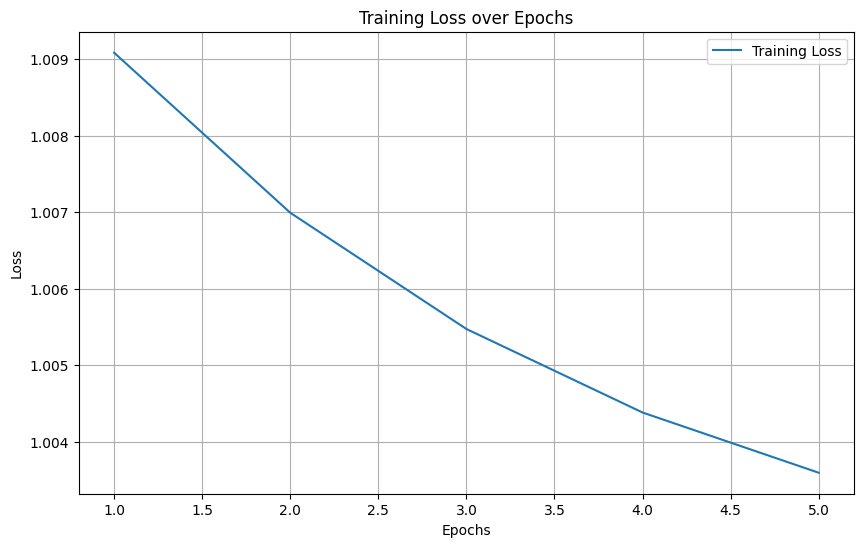

Training loss plot saved as 'training_loss_plot.png'


In [9]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, config["epochs"] + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_plot.png')
plt.show()
print("Training loss plot saved as 'training_loss_plot.png'")

In [10]:
count=1
for it, data in enumerate(train_loader):
    data = data.to(device)
    A = torch.sparse_coo_tensor(data.edge_index, data.edge_attr.squeeze(), requires_grad=False)
    if count==1:
        print(A)
        print(data)
        break
    count+=1

tensor(indices=tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
                        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
                        56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
                        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                        98,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                        41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
                        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
                        69, 70, 71, 72, 